In [ ]:
# -*- coding: utf-8 -*-
#  Copyright 2023 Technical University of Denmark
#
#  Licensed under the GNU General Public License, Version 3 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.gnu.org/licenses/gpl-3.0.en.html
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by: Aksel Kaastrup Rasmussen (Technical University of Denmark)
#  Edited by: Chao Zhang (Technical University of Denmark)

# A Bayesian approach to inverse Robin problems
### Aksel Kaastrup Rasmussen (akara@dtu.dk)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import dolfin as dl
import ufl
import cuqipy_fenics
import cuqi
import warnings

dl.set_log_level(dl.LogLevel.ERROR)
warnings.filterwarnings("ignore")

[dff3218800fc:04530] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


In [ ]:
# Set seed
np.random.seed(0)

In [ ]:
print(cuqi.__version__)


In this Jupyter notebook, we explore a Bayesian approach to an inverse Robin problem. We tackle the problem of recovering a positive function $\beta$ from a noisy observation of the solution to
\begin{align}\nonumber
    \Delta u &= 0 \qquad &&\text{ in $\mathcal{O}$},\\ \nonumber
    \partial_{\nu} u &= h &&\text{ on $\Gamma$},\\ \nonumber
    u &= 0 && \text{ on $\Gamma_0$},\\ \nonumber
    \partial_{\nu} u + \beta u &= 0 &&\text{ on $\Gamma_\beta$},
\end{align}
for some given function $h$. The figure below illustrates the setup.

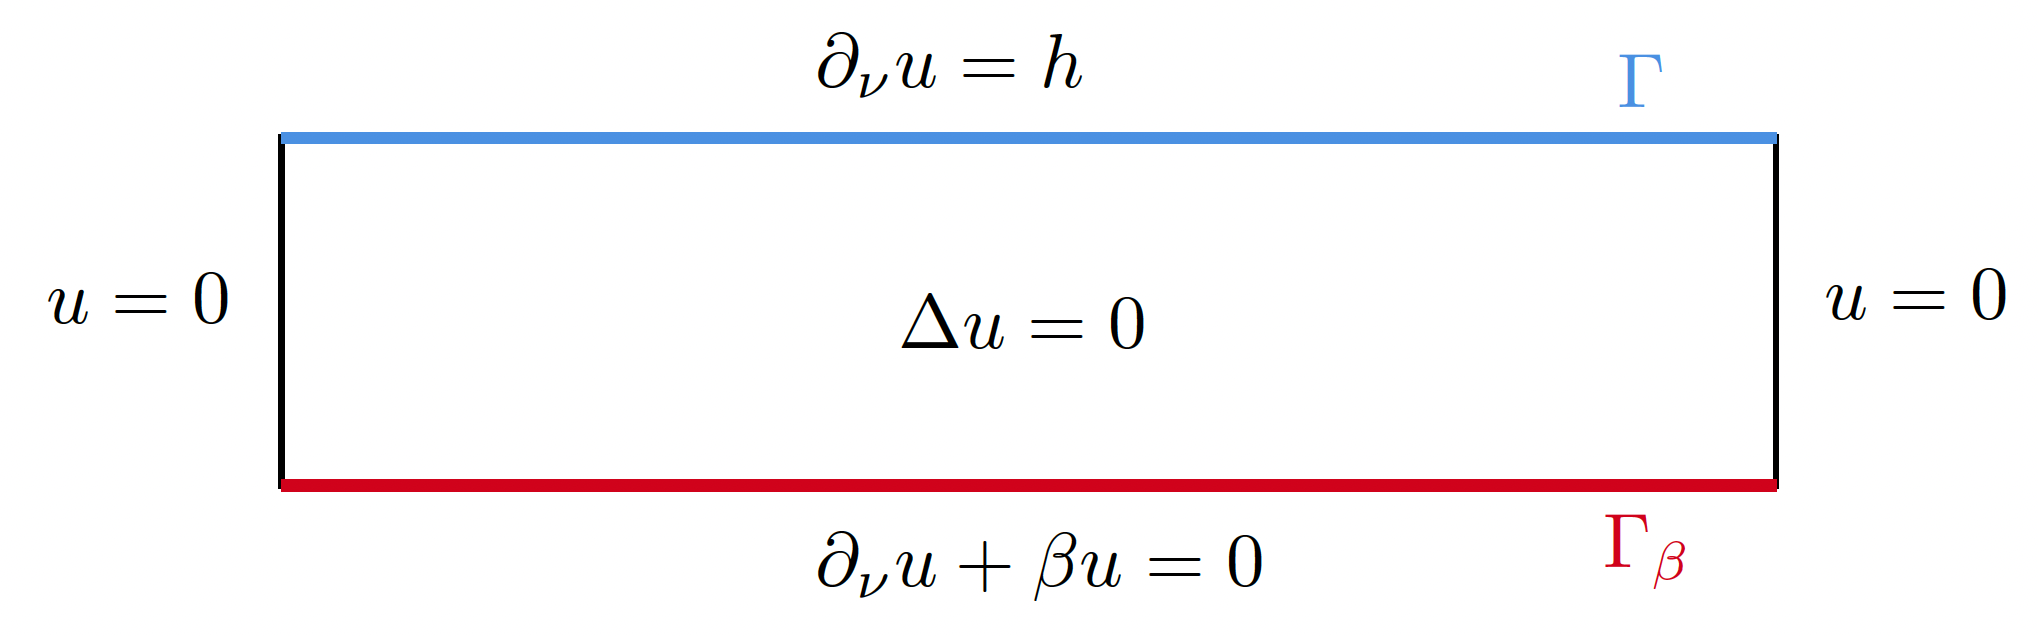


Our observations are on the form
$$Y = u + \varepsilon,$$
or
$$Y = u|_{\Gamma} + \varepsilon,$$
where $\varepsilon\sim N(0,\delta^2 I)$ for some noise level $\delta>0$. The dimension of this vector is the number of vertices in a tringular mesh of $\mathcal{O}$ or the number of vertices on $\Gamma$ depending on the observation model. The problem of estimating $\beta$ from $Y$ is known as in inverse Robin problem and it has exiciting applications in corrosion detection and even initilization problems of large-scale glacier modelling. In this notebook our goals are as follows:
1. Reduce the dimension of the inference problem on $\beta$ to simplify the setting.
2. Implement forward maps $\beta \mapsto u$ and $\beta \mapsto u|_\Gamma$ and their gradients 
3. Use the custom CUQIpy model and test different gradient-based MCMC samplers of CUQIpy


## 1. Dimension reduction 

To make our problem simpler, we assume that $\beta$ is a linear function. The inverse problem is then a two-dimensional parameter estimation problem. For example, given $\theta=(\theta_0,\theta_1)$ we can parametrize linear and positive $\beta$ as 
$$\beta(\theta)(x) = (e^{\theta_1}-e^{\theta_0})\cdot x + e^{\theta_0}.$$
Let us try to plot this linear function:

Text(0.75, 7.38905609893065, 'exp(theta1)')

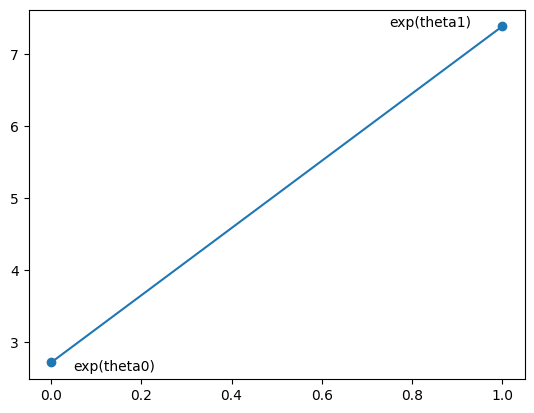

In [1]:
# pick theta0 and theta1
theta0, theta1 = 1,2

# plot
x = np.linspace(0,1,100)
plt.plot(x,(np.exp(theta1)-np.exp(theta0))*x+np.exp(theta0))
plt.scatter([0,1],[np.exp(theta0),np.exp(theta1)])
plt.annotate('exp(theta0)',(0.05,2.6))
plt.annotate('exp(theta1)',(0.75,np.exp(theta1)))

The problem is in this manner reduced from recovering $\beta$ to recovering $\theta\in \mathbb{R}^2$. Of course we can generalize this!


## 2. Implement forward maps and gradients using FEniCS
We start by defining our rectangular domain $\mathcal{O}=(0,1)\times (0,0.1)$, and a convenient plotting function, which is used later.

In [3]:
def _create_boundaries_subdomains():
    """
    Create subdomains for the boundary conditions.
    """
    class Left(dl.SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and x[0] < dl.DOLFIN_EPS

    class Bottom(dl.SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and x[1] < dl.DOLFIN_EPS

    class Right(dl.SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and x[0] > 1.0 - dl.DOLFIN_EPS

    class Top(dl.SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and x[1] > 0.1 - dl.DOLFIN_EPS

    return [Left(), Bottom(), Right(), Top()]


def _set_up_dirichlet_bcs( V, bc_types, bc_values, subdomains):
    """
    Set up Dirichlet boundary conditions for the Poisson PDE problem defined
    on the unit square mesh, where V is the function space.
    """
    dirichlet_bcs = []

    for i, bc in enumerate(bc_types):
        if bc.lower() == 'dirichlet':
            dirichlet_bcs.append(dl.DirichletBC(
                V, bc_values[i], subdomains[i]))

    return dirichlet_bcs

def plot_samples(samples,ax= None,n=5, percentile_min=0, percentile_max=100, color='g', plot_mean=True, plot_median=False, line_color='k', **kwargs):
    x = np.linspace(0,1,100)
    beta = lambda x,tht: (tht[1]-tht[0])*x + tht[0]
    y = np.array(list(map(lambda y: beta(x,y),samples.T)))
    perc1 = np.percentile(y, np.linspace(percentile_min, 50, num=n, endpoint=False), axis=0)
    perc2 = np.percentile(y, np.linspace(50, percentile_max, num=n+1)[1:], axis=0)

    if 'alpha' in kwargs:
        alpha = kwargs.pop('alpha')
    else:
        alpha = 1/n

    # fill lower and upper percentile groups
    for p1, p2 in zip(perc1, perc2):
        if ax:
            ax.fill_between(x, p1, p2, alpha=alpha, color=color)
        else:
            plt.fill_between(x, p1, p2, alpha=alpha, color=color) 

    if ax:
        ax.plot(x,perc1.T,linestyle='--',color='gray',alpha=0.3)
        ax.plot(x,perc2.T,linestyle='--',color='gray',alpha=0.3)
        if plot_mean:
            ax.plot(x, np.mean(y, axis=0), '--r',label='Mean')
        return
    else:
        plt.plot(x,perc1.T,linestyle='--',color='gray',alpha=0.3)
        plt.plot(x,perc2.T,linestyle='--',color='gray',alpha=0.3)
        if plot_mean:
            plt.plot(x, np.mean(y, axis=0),'--r',label='Mean')
            plt.plot(x, np.median(y, axis=0), '--k',label='Median')
        return plt.gca()

The mesh is rather flat in this example.

In [4]:
dim = (100, 10)
mesh = dl.RectangleMesh(dl.Point(0, 0), dl.Point(1, 0.1), dim[0], dim[1])

# creating subboundaries
subdomains = _create_boundaries_subdomains()

# plot mesh
mesh

We then define a first order Lagrange function space for the rectangular domain and the interval $(0,1)$. We also define subdomains for each type of boundary condition. 

In [5]:
# Create the function space
V = dl.FunctionSpace(mesh, 'Lagrange', 1)
mesh_1d = dl.IntervalMesh(100, 0, 1)
V_1d = dl.FunctionSpace(mesh_1d,'Lagrange', 1)


# Define boundary condition type for subdomains
bc_types = ['Dirichlet', 'invalid', 'Dirichlet', 'Neumann']
bc_values = [dl.Constant(0), None, dl.Constant(0), dl.Expression("20+10*sin(10*2*pi*x[0])", degree=1)]

# Set up Dirichlet boundary conditions
dirichlet_bcs = _set_up_dirichlet_bcs(
    V, bc_types, bc_values, subdomains)

# Define boundary markers
boundary_markers = dl.MeshFunction(
    'size_t', V.mesh(), V.mesh().topology().dim()-1)
boundary_markers.set_all(0)
for i, subdomain in enumerate(subdomains):
    subdomain.mark(boundary_markers, i+1)

# Define measure for each subdomain
ds = dl.Measure('ds', domain=V.mesh(), subdomain_data=boundary_markers)


We build a class $\texttt{Beta}$, which allows to interface the parametrized $\beta$ easily with Fenics and utilize the JIT compiler.

In [6]:
class restrictor(dl.UserExpression):
    def __init__(self,fun,rp,degree=1,*args,**kwargs):
        super().__init__(self,fun,rp,degree,**kwargs)
        self.fun = lambda x: fun(x,rp)

    def value_shape(self):
        return ()
    
    def eval(self,values,x):
        values[0] = self.fun(x[0])


class Beta(dl.UserExpression):
    def build_beta(self):
        exp_theta = np.exp(self.theta)
        #print(exp_theta)
        self.a = exp_theta[1]-exp_theta[0]
        self.b = exp_theta[0]

    def __init__(self,theta,degree=1,*args,**kwargs):
        super().__init__(self,theta,degree,**kwargs)
        self.theta=theta
        self.build_beta()
        self.degree = degree

    def value_shape(self):
        return (3,)
    
    def eval(self,values,x):
        values[0] = self.a*x[0] + self.b
        #-exp(theta__0)*x + exp(theta__0)
        values[1] = np.exp(self.theta[0])*(1-x[0])
        values[2] = np.exp(self.theta[1])*x[0]

The following class defines a PDE object with a forward map function, Jacobian function and gradient function. 
Note for this PDE problem, the variational form is of the form
\begin{equation}
 \int_{\mathcal{O}} \nabla u  \cdot \nabla v + \int_{\Gamma_\beta} \beta u v = \int_{\Gamma} hv 
\end{equation}
for $v \in V := \{u\in H^1(\mathcal{O}):u|_{\Gamma_0}=0\}$. This is straightforward to implement in FEniCS as us done below.

The gradient of $u$ with respect to $\theta_i$ can be found as the solution to
$$\int_{\mathcal{O}} \nabla u \cdot \nabla v + \int_{\Gamma_\beta}\beta(\theta) u v = \int_{\Gamma_\beta} (\partial_{\theta_i}\beta)(\theta) u^0 v,$$
where $u_0$ solves $(1)$ above for $\beta=\beta(\theta)$. This has also been implemented below. 
The gradient of $u|_{\Gamma}$ with respect to $\theta_i$ is just the gradient found above, but restricted to $\Gamma$, since this restriction is linear.

In [78]:
class MyPDE:
    def __init__(self,restrict=False,*args,**kwargs):
        self.solver = dl.LUSolver()
        # Beta parameters
        self.beta = Beta([0,0])
        # operator
        self.p_trial = dl.TrialFunction(V)
        self.p_test = dl.TestFunction(V)
        self.L_op = dl.assemble(ufl.inner(self.p_trial, self.p_test)*ds(2))
        self.restrict=restrict
        if restrict:
            self.restrictor = lambda fun: restrictor(fun,restrict)
            self.restrict = True
            
    # Assembles lhs and rhs of the variational form and solves
    def forward(self, theta):
        u0 = dl.Function(V)
        #print("teta inside forward:", theta)
        A = dl.assemble(self.form_u0_lhs(theta, self.p_test, self.p_trial))
        self.A=A
        #print("norm of A", np.linalg.norm(A.array()))
        for bc in dirichlet_bcs:
            bc.apply(A)

        
        #self.solver = dl.LUSolver()
        self.solver.set_operator(A)
        b = dl.assemble(self.form_u0_rhs(theta, self.p_test, self.p_trial))
        for bc in dirichlet_bcs:
            bc.apply(b)
        #for bc in dirichlet_bcs:
        #    bc.apply(A, b)

        #dl.solve(A, u0.vector(), b)
        self.solver.solve(u0.vector(), b)
        if self.restrict:
            self.u0r = u0
            rs = self.restrictor(u0)
            return dl.interpolate(rs,V_1d)
        else:
            return u0
    
    # Computes Jacobian based on solving two PDEs 
    def jacobian(self, theta):
        u0 = self.forward(theta)
        if self.restrict:
            u0 = self.u0r
            
        # Create the directions 
        # Beta
        u1 = dl.TrialFunction(V)
        self.beta.theta = theta
        self.beta.build_beta() 
        beta_dim =  self.beta.value_shape()[0]-1
        #bf  =  dl.project(self.beta[0],V)
        bdir = [dl.project(self.beta[1], V),dl.project(self.beta[2], V)]
        
        lhs = dl.assemble(ufl.inner(ufl.grad(u1), ufl.grad(self.p_test))*ufl.dx + self.beta[0]*u1*self.p_test*ds(2))
        for bc in dirichlet_bcs:
            bc.apply(lhs)
            
        if self.restrict:
            Jac = np.empty((V_1d.dim(),beta_dim))
        else:
            Jac = np.empty((V.dim(),beta_dim))
            
        for idx in range(beta_dim):
            #b =  self.L_op*(-1*self.beta[idx+1]*(self.beta[0]-1))
            rhs = dl.assemble(-u0*self.beta[idx+1]*self.p_test*ds(2)) #*(bf.vector()-1))
            for bc in dirichlet_bcs:
                bc.apply(rhs)
        
            p_sol = dl.Function(V)
            dl.solve(lhs,p_sol.vector(), rhs)
            if self.restrict:
                rs = self.restrictor(p_sol)
                tmp = dl.interpolate(rs,V_1d)
                Jac[:,idx] = tmp.vector()
            else:
                Jac[:, idx] = p_sol.vector()

        return Jac
    
    def gradient(self, direction, theta):
        #print("direction:", direction.vector().get_local())
        #print("theta:", theta)
        jac = self.jacobian(theta)
        #print("jac:", jac)
        return direction.vector().get_local()@jac
    
    def form_u0_lhs(self, theta, u, p):
        #beta = function_mapping(kl_coeff)
        #beta = self.beta.build_beta(theta)
        #beta_fun = dl.interpolate(beta, V)
        self.beta.theta = theta
        self.beta.build_beta()

        #beta_fun = dl.Function(V)
        #beta_fun.interpolate(beta)
        return ufl.inner(ufl.grad(u), ufl.grad(p))*ufl.dx + self.beta[0]*u*p*ds(2)
    
    def form_u0_rhs(self, theta, u, p):
        return  bc_values[3]*p*ds(4) 

Let us try to look at a solution of the PDE. Note, below we have the option to either consider observations everywhere in $\mathcal{O}$ or restricted to $y=0.1$. 

Text(0.5, 1.0, 'Solution of PDE')

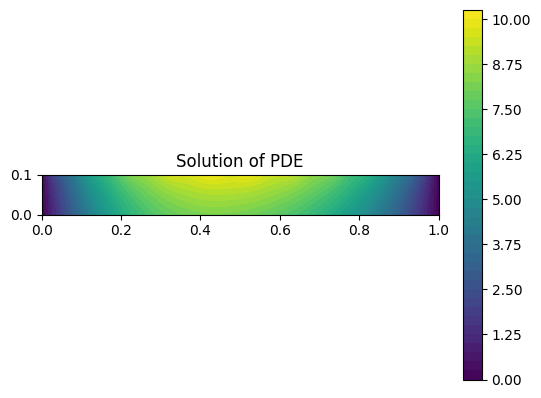

In [79]:
## Solution of PDE
# Make object
robinPDE = MyPDE()
RestrictedRobinPDE = MyPDE(restrict=0.1)

# Get solution for theta0 = 0, theta1 = 1
sol = robinPDE.forward([0,1])
RestrictedSol = RestrictedRobinPDE.forward([0,1])

# Plot
p = dl.plot(sol)
plt.colorbar(p)
plt.title('Solution of PDE')

The restricted solution to $y=0.1$ then looks like the following:

Text(0.5, 1.0, 'Restricted Solution of PDE')

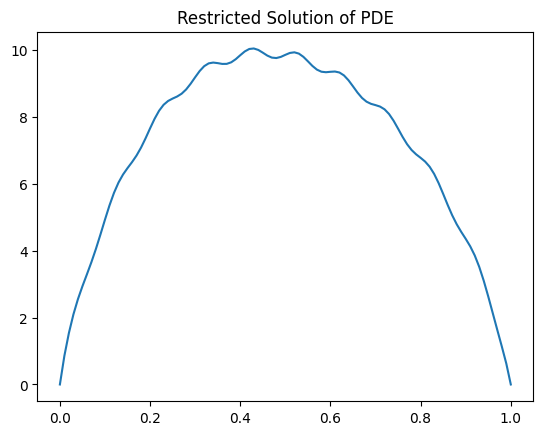

In [80]:
p = dl.plot(RestrictedSol)
plt.title('Restricted Solution of PDE')

One should check that the gradient is implemented correctly. We do this by finite differences.

Text(0.5, 1.0, 'Difference of finite difference gradient and analytic')

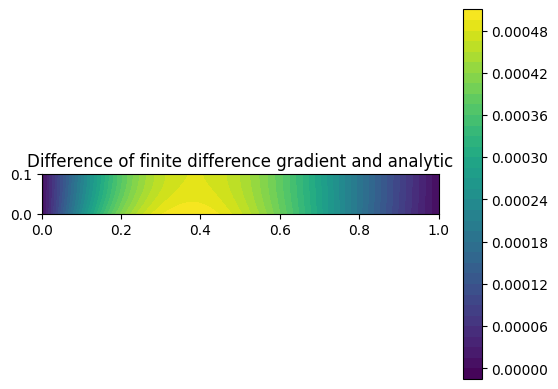

In [81]:
# Finite difference gradient in the first direction
theta = [0,1]
theta_h = theta.copy()
h = 0.001
theta_h[0] += h

sol =  robinPDE.forward(theta)
sol_h = robinPDE.forward(theta_h)
fd_grad = (sol_h-sol)/h

# "Analytic" gradient
sol_grad = dl.Function(V)
jacobian = robinPDE.jacobian(theta)
sol_grad.vector().set_local(jacobian[:, 0])

# Plot
plt.figure()
im = dl.plot(dl.project(sol_grad-fd_grad, V))
plt.colorbar(im)
plt.title('Difference of finite difference gradient and analytic')

Text(0.5, 1.0, 'Difference of finite difference gradient and analytic')

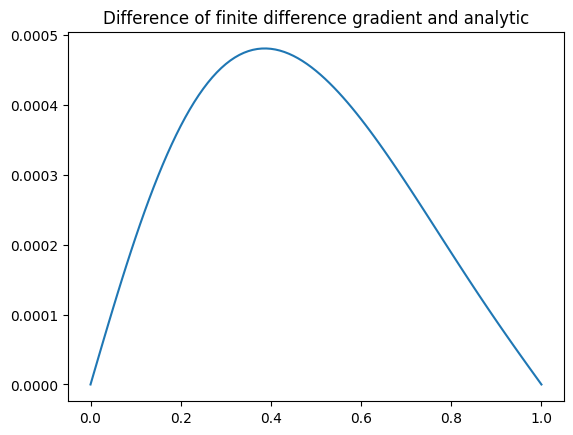

In [82]:
# Finite difference gradient in the first direction
theta = [0,1]
theta_h = theta.copy()
h = 0.001
theta_h[0] += h

RestrictedSol =  RestrictedRobinPDE.forward(theta)
RestrictedSol_h = RestrictedRobinPDE.forward(theta_h)
Restrictedfd_grad = (RestrictedSol_h-RestrictedSol)/h

# "Analytic" gradient
RestrictedSol_grad = dl.Function(V_1d)
RestrictedJacobian = RestrictedRobinPDE.jacobian(theta)
RestrictedSol_grad.vector().set_local(RestrictedJacobian[:, 0])

# Plot
plt.figure()
dl.plot(RestrictedSol_grad-Restrictedfd_grad)
#plt.colorbar(im)
plt.title('Difference of finite difference gradient and analytic')

## 3. Use CUQIpy for Bayesian inference
The observation model specifies a likelihood function of $\theta\in \mathbb{R}^2$. To recover these parameters, we specify a Gaussian prior on them. CUQIpy then allows using our Fenics-based forward model as a custom model. Furthermore, if we specify a gradient procedure, it also allows gradient-based MCMC sampling for the corresponding posterior distribution. But for now we only specify the forward map.

We construct a CUQI model in the following.

In [55]:
G_domain = cuqi.geometry.Discrete(len(robinPDE.beta.theta))
G_range = cuqipy_fenics.geometry.FEniCSContinuous(V)
A = cuqi.model.Model(forward=robinPDE.forward, domain_geometry=G_domain, range_geometry=G_range)


We set the ground truth $\underline{\theta}=(1,2)$ and compute the exact data.

In [56]:
np.random.seed(0)
exact_theta = [0,0] #exact_theta
exact_theta[0] = 1
exact_theta[1] = 2
y_exact = A(exact_theta)

For simplificty, we specify Gaussian prior on $\theta \in \mathbb{R}^2$
$$\theta \sim N \left(\begin{bmatrix} 1/2 \\ 1/2 \end{bmatrix}, I \right)$$
What does that look like?

Plotting 5 randomly selected samples


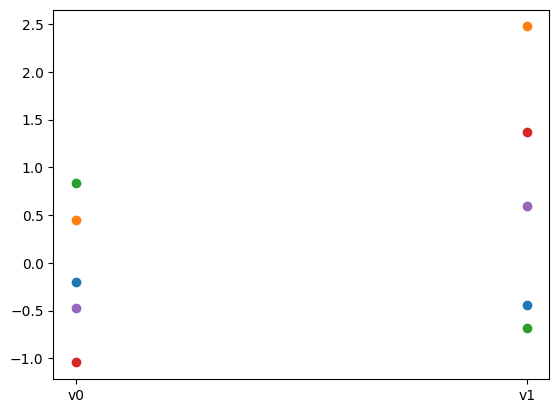

In [22]:
# Prior
theta = cuqi.distribution.Gaussian(0.5*np.ones(G_domain.par_dim), np.eye(G_domain.par_dim))

# Plot samples of the prior
prior_samples = theta.sample(10)
#plot_samples(np.exp(prior_samples.samples))

# Consider samples as two-dimensional discrete for plotting
new_geom = cuqi.geometry.Discrete(2)
prior_samples.geometry = new_geom
prior_samples.plot()

We define the likelihood function from the CUQI custom model $A$ defined above and Gaussian noise. Here we use 20% relative noise.

In [23]:
# Noise
noise_level = 0.2
noise = np.random.randn(len(y_exact))
noise_std = noise_level * \
    np.linalg.norm(y_exact)/np.linalg.norm(noise)
noise = noise_std*noise

# Add noise to the exact solution
data = y_exact + noise

# Define datadistribution
data_dist = cuqi.distribution.Gaussian(mean=A(theta), cov=noise_std**2, geometry=G_range,name='y')

The prior and likelihood is collecected to a joint distribution which we evaluate in the noisy data realization $\texttt{data}$ to obtain a posterior object. 

In [24]:
joint = cuqi.distribution.JointDistribution(data_dist, theta)
posterior = joint(y = data)
data_dist

CUQI Gaussian. Conditioning variables ['theta'].

Initially we use the preconditioned Crank-Nicolson (pCN) sampler to sample from the posterior with 3000 samples after a 1000 burnin.

 Sample 4000 / 4000

Average acceptance rate: 0.27 MCMC scale: 0.026705807605050307 



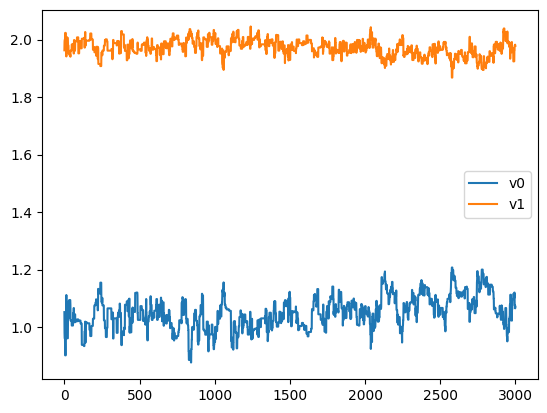

In [31]:
# Use pCN sampler with 3000 samples after a 1000 burnin.
sampler1 = cuqi.sampler.pCN(posterior, x0=[0,0])
samples1= sampler1.sample_adapt(3000,1000)
samples1.plot_chain()


CUQIpy can show us the autocorrelation of the samples:

array([<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v1'}>],
      dtype=object)

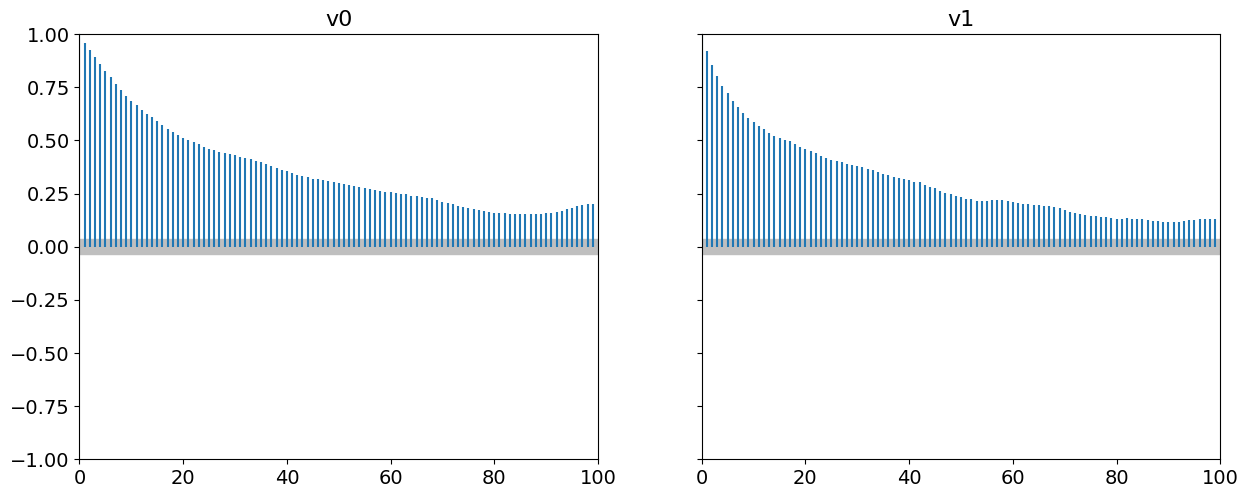

In [32]:
samples1.plot_autocorrelation()

Text(0.5, 1.0, 'Samples from pCN')

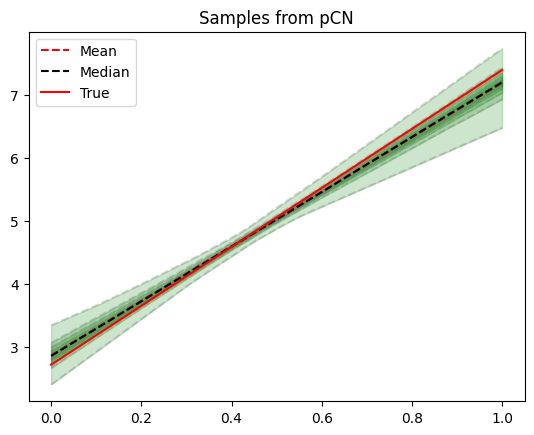

In [41]:
# What does it look like?
samples = np.exp(samples1.samples)
plot_samples(samples)
plt.plot(x,(np.exp(theta1)-np.exp(theta0))*x+np.exp(theta0),c='red',label='True')
plt.legend(loc='best')
plt.title('Samples from pCN')

### Gradient based samplers for the Robin problem

To use gradient based samplers, we simply input our procedure to compute $v \cdot J$, where $J$ is the $N \times 2$ Jacobian of the forward map with respect $\theta=(\theta_0,\theta_1)$ and $N$ is the number of vertices in the mesh. Here $v$ is a given $N$-dimensional direction. This is provided by $\texttt{robinPDE.gradient}$.


In [33]:
A_grad = cuqi.model.Model(forward = robinPDE.forward, 
                          gradient = robinPDE.gradient,
                          domain_geometry=G_domain, 
                          range_geometry=G_range)
data_dist_grad = cuqi.distribution.Gaussian(mean=A_grad(theta), cov=noise_std**2, geometry=G_range,name='y')
joint_grad = cuqi.distribution.JointDistribution(data_dist_grad, theta)
posterior_grad = joint_grad(y = data)

First we sample using an unadjusted Langevin (ULA) sampler. This is implemented in CUQIpy

Sample 300 / 300


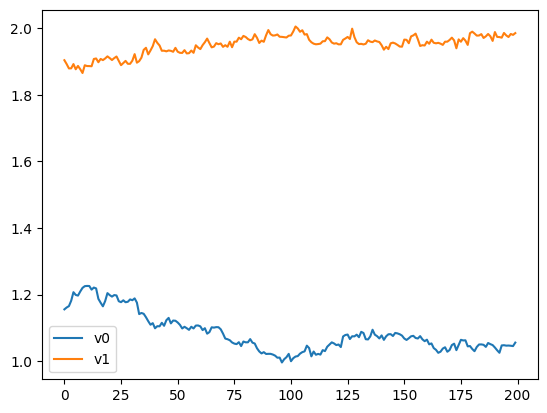

In [34]:
sampler2 = cuqi.sampler.ULA(posterior_grad, x0=[0,0],scale=1e-4)
samples2 = sampler2.sample_adapt(200,100)
samples2.plot_chain()

Autorcorrelation is much better for ULA!

array([<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v1'}>],
      dtype=object)

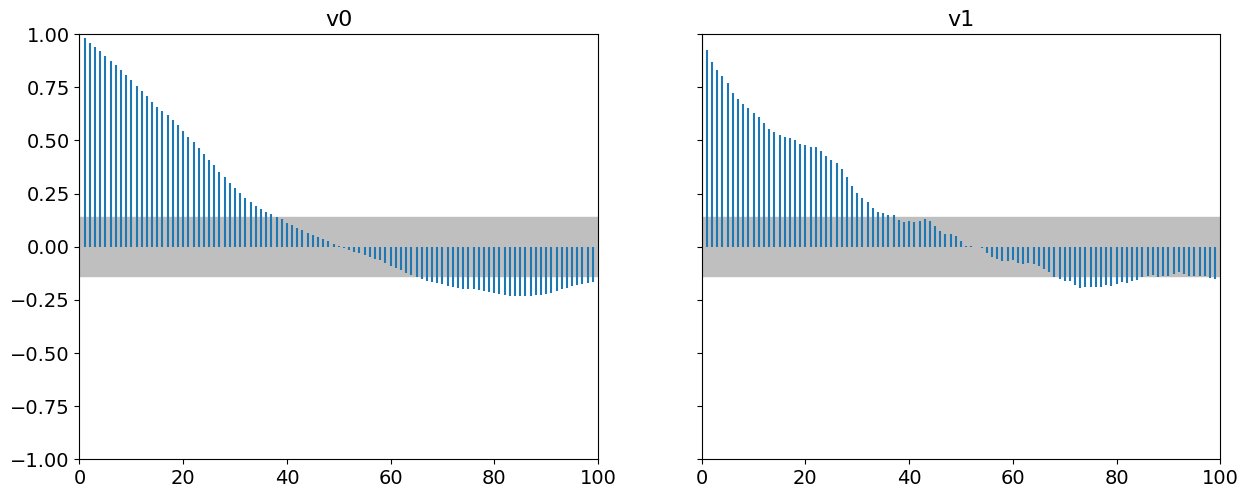

In [43]:
samples2.plot_autocorrelation()

Text(0.5, 1.0, 'Samples from ULA')

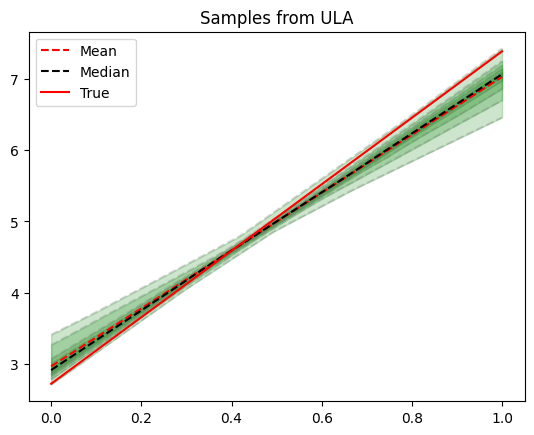

In [44]:
# What does it look like?
samples = np.exp(samples2.samples)
plot_samples(samples)
plt.plot(x,(np.exp(theta1)-np.exp(theta0))*x+np.exp(theta0),c='red',label='True')
plt.legend(loc='best')
plt.title('Samples from ULA')

The mean might be a worse estimate, but we recall that this estimate is based on much fewer samples an a smaller burn-in.

We can try using the Metropolis adjusted Langevin algorithm (MALA) as well:

Sample 300 / 300


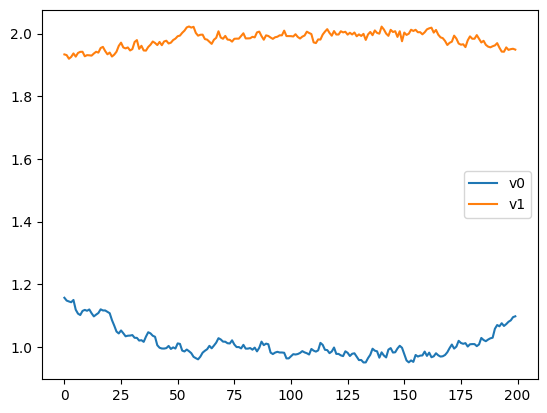

In [45]:
sampler3 = cuqi.sampler.MALA(posterior_grad, x0=[0,0],scale=1e-4)
samples3 = sampler3.sample_adapt(200,100)
samples3.plot_chain()

Also here we plot the autocorrelation, which is even better!

array([<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v1'}>],
      dtype=object)

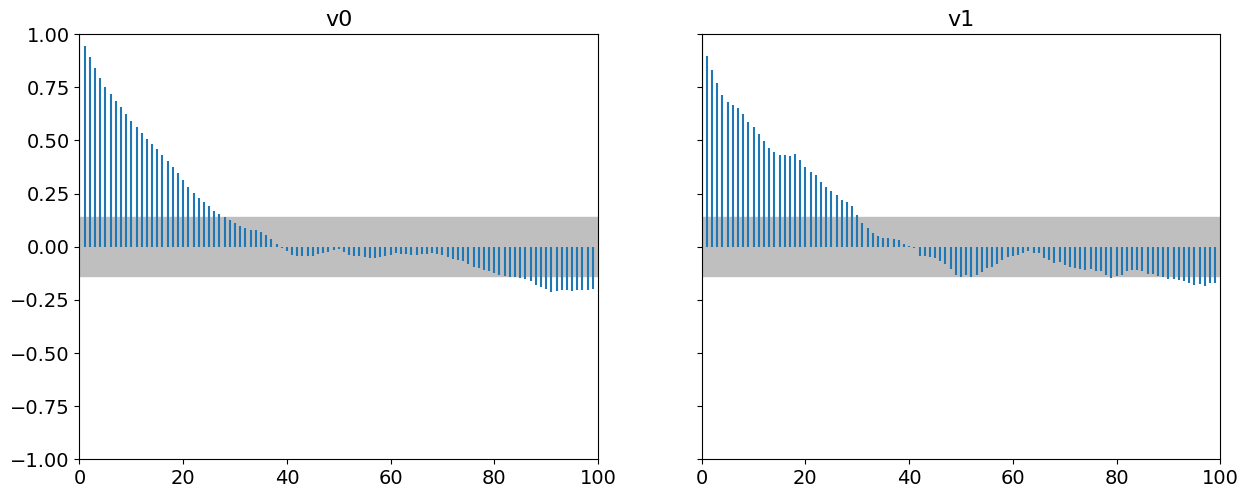

In [46]:
samples3.plot_autocorrelation()

Text(0.5, 1.0, 'Samples from MALA')

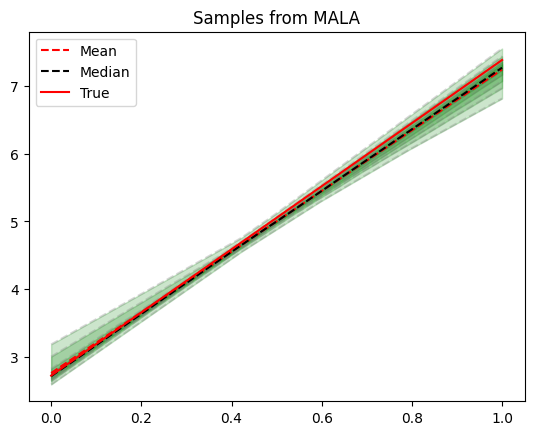

In [47]:
# What does it look like?
samples = np.exp(samples3.samples)
plot_samples(samples)
plt.plot(x,(np.exp(theta1)-np.exp(theta0))*x+np.exp(theta0),c='red',label='True')
plt.legend(loc='best')
plt.title('Samples from MALA')

Finally, we can sample using the well-established Hamiltonian Monte Carlo (HMC) sampler NUTS.

Sample 300 / 300


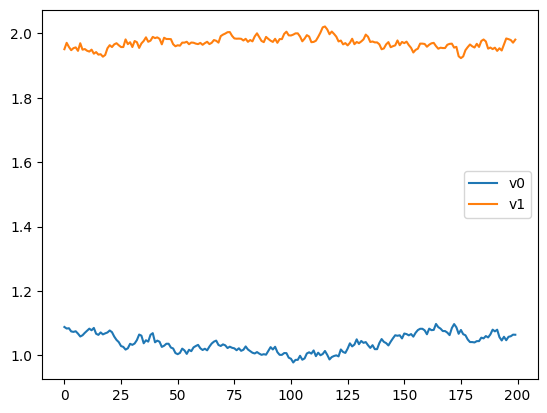

In [48]:
sampler4 = cuqi.sampler.NUTS(posterior_grad, x0=[0,0])
samples4 = sampler3.sample_adapt(200,100)
samples4.plot_chain()

The autocorrelation is the best we have seen and the mean estimates are also reasonable.

array([<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v1'}>],
      dtype=object)

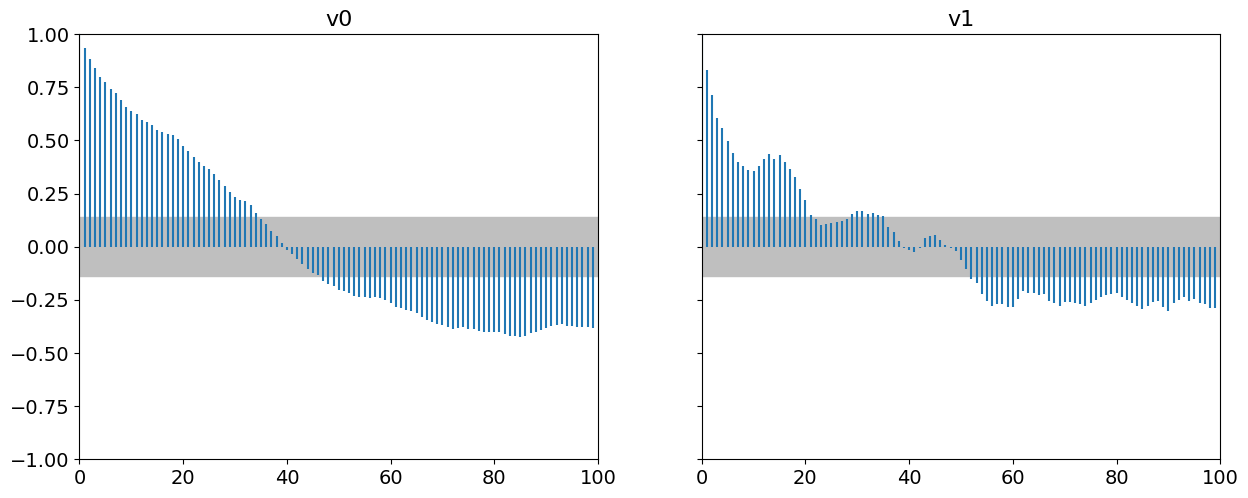

In [49]:
samples4.plot_autocorrelation()

Text(0.5, 1.0, 'Samples from NUTS')

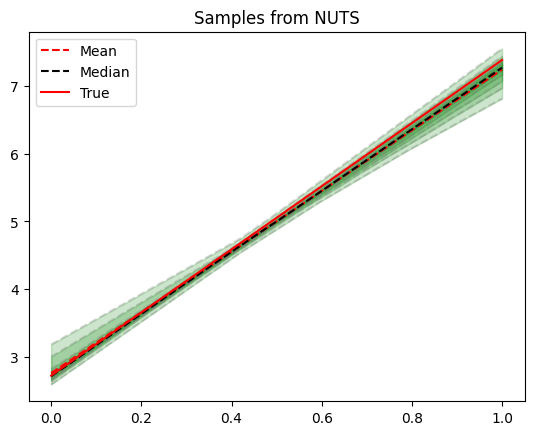

In [50]:
# What does it look like?
samples = np.exp(samples3.samples)
plot_samples(samples)
plt.plot(x,(np.exp(theta1)-np.exp(theta0))*x+np.exp(theta0),c='red',label='True')
plt.legend(loc='best')
plt.title('Samples from NUTS')

Why not compare everything?

Text(0.5, 1.0, 'Samples from NUTS')

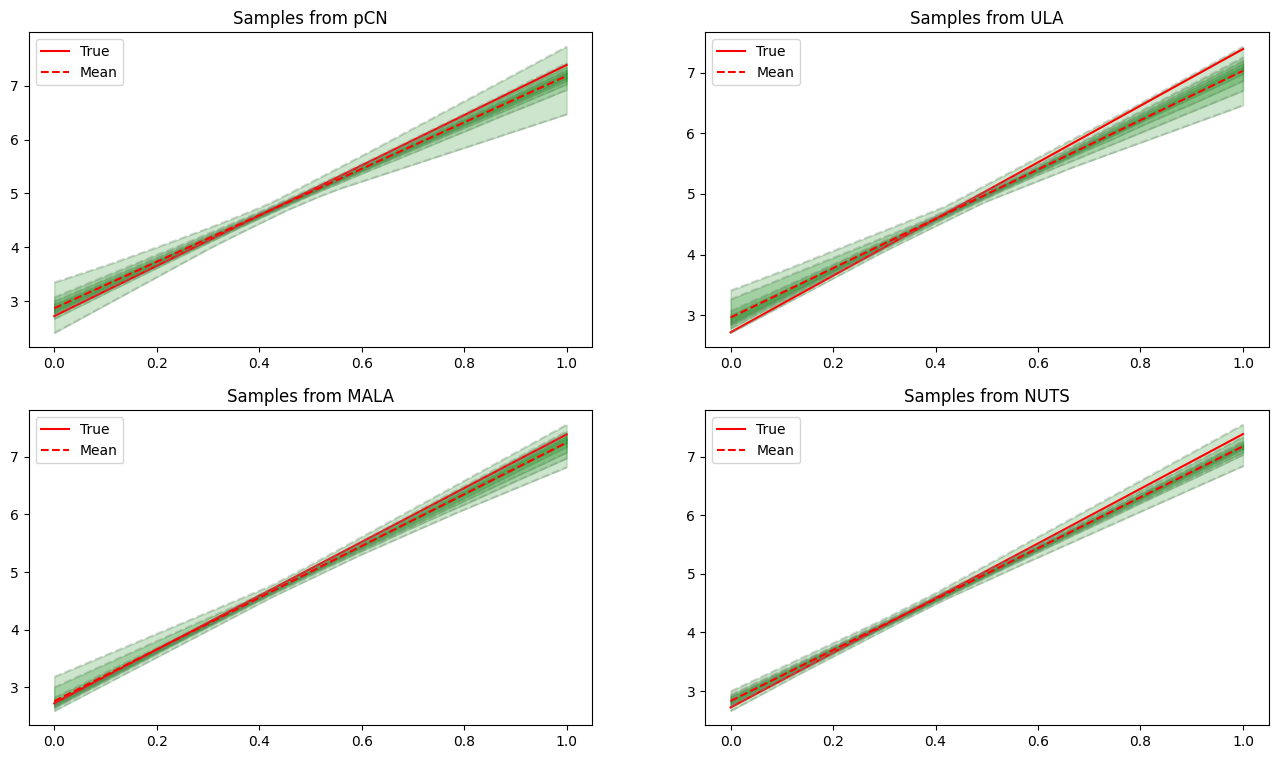

In [55]:
fig,ax = plt.subplots(2,2,figsize=(16,9))
smpl1 = np.exp(samples1.samples)
smpl2 = np.exp(samples2.samples)
smpl3 = np.exp(samples3.samples)
smpl4 = np.exp(samples4.samples)

ax[0,0].plot(x,(np.exp(theta1)-np.exp(theta0))*x+np.exp(theta0),c='red',label='True')
plot_samples(smpl1,ax[0,0])
ax[0,0].legend(loc='best')
ax[0,0].set_title('Samples from pCN')

ax[0,1].plot(x,(np.exp(theta1)-np.exp(theta0))*x+np.exp(theta0),c='red',label='True')
plot_samples(smpl2,ax[0,1])
ax[0,1].legend(loc='best')
ax[0,1].set_title('Samples from ULA')

ax[1,0].plot(x,(np.exp(theta1)-np.exp(theta0))*x+np.exp(theta0),c='red',label='True')
plot_samples(smpl3,ax[1,0])
ax[1,0].legend(loc='best')
ax[1,0].set_title('Samples from MALA')

ax[1,1].plot(x,(np.exp(theta1)-np.exp(theta0))*x+np.exp(theta0),c='red',label='True')
plot_samples(smpl4,ax[1,1])
ax[1,1].legend(loc='best')
ax[1,1].set_title('Samples from NUTS')